## Credit Card Fraud Detection – Anomaly Detection

### Introduction

Fraud detection is critical for financial institutions. This project uses machine learning (Logistic
Regression, Random Forest, Isolation Forest) to identify fraudulent transactions.

In [3]:
import numpy as np 
import pandas as pd 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_curve,roc_auc_score,classification_report, confusion_matrix, average_precision_score, auc
import warnings
warnings.filterwarnings('ignore')

### LOAD PACKAGES

In [5]:
df = pd.read_csv("creditcard.csv")
print(df['Class'].value_counts(normalize=True))  # Check fraud percentage


Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


The dataset is heavily imbalanced, typically ~0.17% fraud.

# Preprocessing
Scale features: Amount and Time often need normalization.

In [8]:
from sklearn.preprocessing import StandardScaler

df['scaled_amount'] = StandardScaler().fit_transform(df[['Amount']])
df['scaled_time'] = StandardScaler().fit_transform(df[['Time']])
df.drop(['Amount', 'Time'], axis=1, inplace=True)


# Handle Class Imbalance
Option A: Undersampling

In [11]:
from sklearn.utils import resample

df_majority = df[df.Class == 0]
df_minority = df[df.Class == 1]

df_majority_downsampled = resample(df_majority, 
                                   replace=False,
                                   n_samples=len(df_minority)*5, 
                                   random_state=42)

df_balanced = pd.concat([df_majority_downsampled, df_minority])


In [12]:
from imblearn.over_sampling import SMOTE

X = df.drop('Class', axis=1)
y = df['Class']
X_resampled, y_resampled = SMOTE().fit_resample(X, y)


# Model Training and Evaluation
Logistic Regression, Random Forest, Isolation Forest

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

In [22]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [24]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [25]:
# Isolation Forest
iso = IsolationForest(contamination=0.0017)
iso.fit(X_train)
y_pred_iso = iso.predict(X_test)
y_pred_iso = [1 if p == -1 else 0 for p in y_pred_iso]

## Evaluation Metrics

In [29]:
from sklearn.metrics import roc_curve, RocCurveDisplay, ConfusionMatrixDisplay

for model, y_pred in zip(['LogReg', 'RandomForest', 'IsolationForest'],
                         [y_pred_lr, y_pred_rf, y_pred_iso]):
    print(f"\n{model} Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))



LogReg Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     85149
           1       0.97      0.92      0.95     85440

    accuracy                           0.95    170589
   macro avg       0.95      0.95      0.95    170589
weighted avg       0.95      0.95      0.95    170589

Confusion Matrix:
[[83051  2098]
 [ 6829 78611]]

RandomForest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85149
           1       1.00      1.00      1.00     85440

    accuracy                           1.00    170589
   macro avg       1.00      1.00      1.00    170589
weighted avg       1.00      1.00      1.00    170589

Confusion Matrix:
[[85132    17]
 [    0 85440]]

IsolationForest Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     85149
           1       1.00      0.

# Visualisation

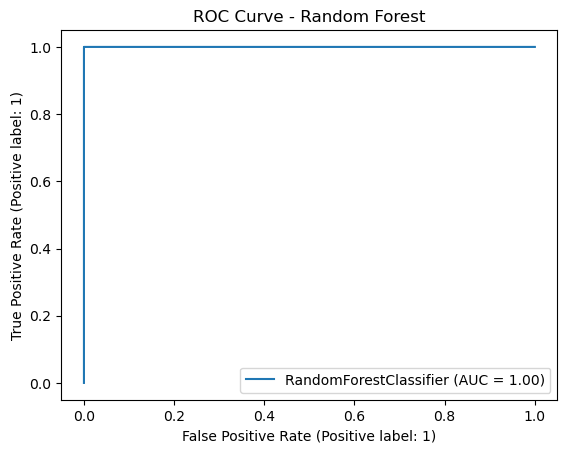

In [31]:
import matplotlib.pyplot as plt

RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.title("ROC Curve - Random Forest")
plt.show()


## Threshold Optimization

In [33]:
y_scores = rf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Example: find threshold for TPR > 0.90
optimal_idx = next(i for i, t in enumerate(tpr) if t > 0.9)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold (TPR > 0.9): {optimal_threshold}")


Optimal threshold (TPR > 0.9): 1.0


## Feature Importance

In [35]:
importances = rf.feature_importances_
feature_names = X.columns
sorted_idx = importances.argsort()[-10:]
print("Top features:")
for idx in sorted_idx[::-1]:
    print(f"{feature_names[idx]}: {importances[idx]:.4f}")


Top features:
V14: 0.1466
V10: 0.1400
V12: 0.1256
V4: 0.1096
V11: 0.0871
V17: 0.0786
V16: 0.0506
V7: 0.0318
V3: 0.0312
V2: 0.0222


# Resampled Fraud Detection – Compare Random Forest vs Logistic Regression


===== Random Forest =====


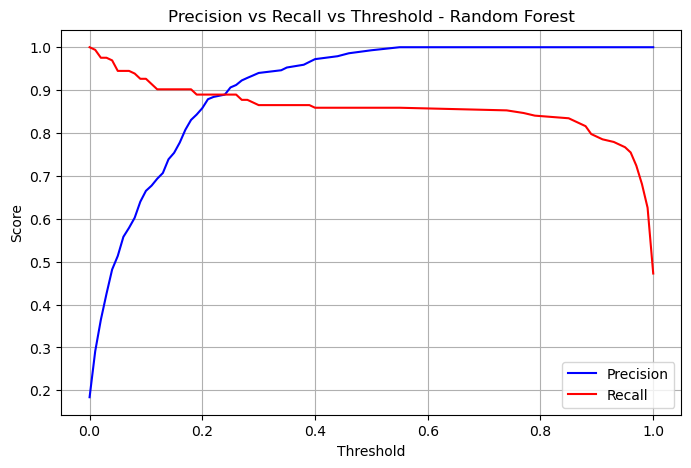

Confusion Matrix (threshold = 0.3):
 [[714   9]
 [ 22 141]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       723
           1       0.94      0.87      0.90       163

    accuracy                           0.97       886
   macro avg       0.96      0.93      0.94       886
weighted avg       0.96      0.97      0.96       886



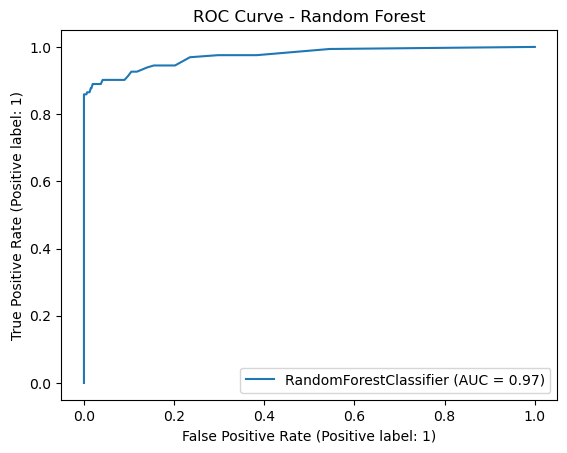


===== Logistic Regression =====


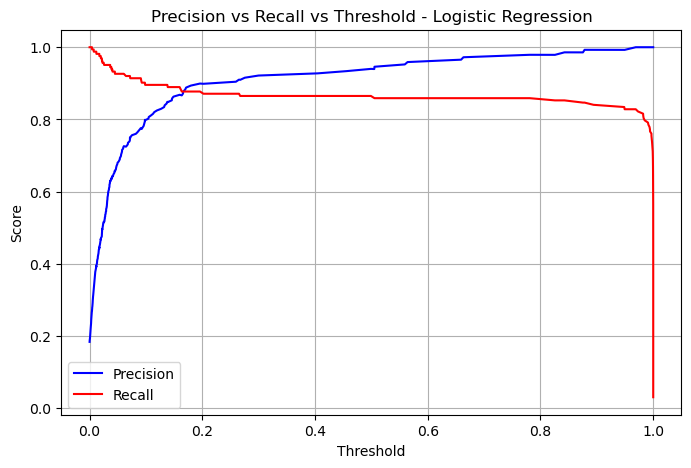

Confusion Matrix (threshold = 0.3):
 [[712  11]
 [ 22 141]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       723
           1       0.93      0.87      0.90       163

    accuracy                           0.96       886
   macro avg       0.95      0.92      0.94       886
weighted avg       0.96      0.96      0.96       886



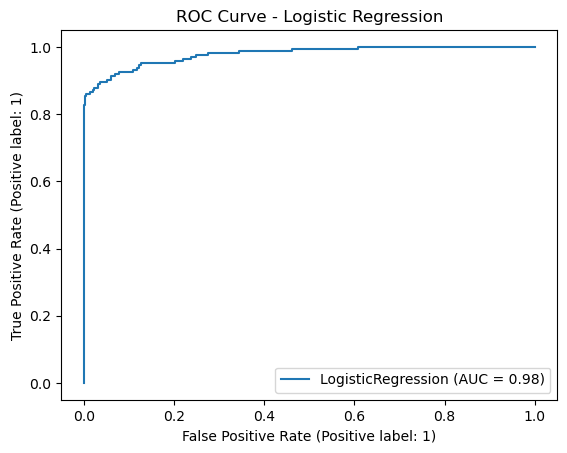

In [51]:
# Step 1: Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    RocCurveDisplay,
    precision_recall_curve
)
from sklearn.utils import resample


# Scale 'Amount' and 'Time'
df['scaled_amount'] = StandardScaler().fit_transform(df[['scaled_amount']])
df['scaled_time'] = StandardScaler().fit_transform(df[['scaled_time']])
df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)

# Step 3: Random Undersampling
df_majority = df[df['Class'] == 0]
df_minority = df[df['Class'] == 1]

# Undersample majority to 5x minority
df_majority_downsampled = resample(
    df_majority,
    replace=False,
    n_samples=len(df_minority) * 5,
    random_state=42
)

# Combine and shuffle
df_resampled = pd.concat([df_majority_downsampled, df_minority])
df_resampled = df_resampled.sample(frac=1, random_state=42)

# Step 4: Split Features and Target
X = df_resampled.drop('Class', axis=1)
y = df_resampled['Class']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Step 5: Initialize Models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000)
}

# Step 6: Train, Predict, and Evaluate
for name, model in models.items():
    print(f"\n===== {name} =====")
    model.fit(X_train, y_train)
    
    # Predict probabilities
    y_scores = model.predict_proba(X_test)[:, 1]
    
    # Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
    
    # Plot Precision vs Recall vs Threshold
    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, precision[:-1], label="Precision", color='blue')
    plt.plot(thresholds, recall[:-1], label="Recall", color='red')
    plt.title(f"Precision vs Recall vs Threshold - {name}")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.legend()
    plt.grid()
    plt.show()

    # Use a fixed threshold (can adjust based on plot)
    custom_threshold = 0.3
    y_pred_thresh = (y_scores >= custom_threshold).astype(int)

    # Evaluation
    print(f"Confusion Matrix (threshold = {custom_threshold}):\n", confusion_matrix(y_test, y_pred_thresh))
    print(f"\nClassification Report:\n", classification_report(y_test, y_pred_thresh))

    # ROC Curve
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title(f"ROC Curve - {name}")
    plt.show()


#### predicting probabilities (for Random Forest

In [53]:
from sklearn.metrics import f1_score
import numpy as np

# Search for best threshold based on F1-score
best_thresh = 0
best_f1 = 0
for t in np.arange(0.0, 1.0, 0.01):
    y_pred = (y_scores >= t).astype(int)
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print(f"\nBest threshold based on F1-score: {best_thresh:.2f}")
print(f"Best F1-score: {best_f1:.4f}")

# Apply the best threshold
y_pred_best = (y_scores >= best_thresh).astype(int)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))



Best threshold based on F1-score: 0.67
Best F1-score: 0.9150
Confusion Matrix:
 [[720   3]
 [ 23 140]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98       723
           1       0.98      0.86      0.92       163

    accuracy                           0.97       886
   macro avg       0.97      0.93      0.95       886
weighted avg       0.97      0.97      0.97       886



### Updated Evaluation Block (add inside your loop for each model)

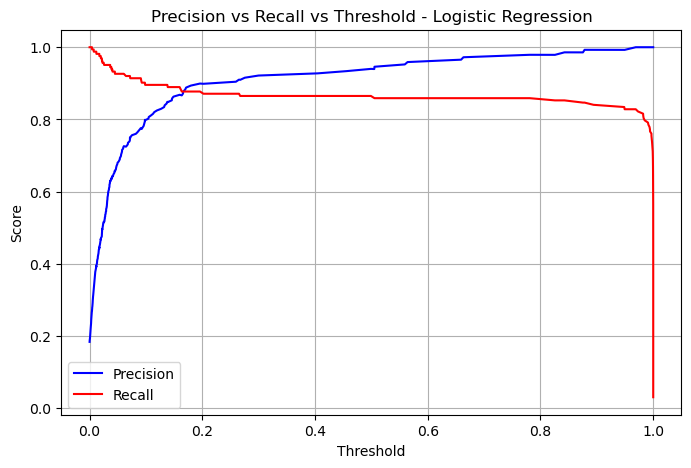


== Logistic Regression | Best threshold (F1-optimized): 0.67 | Best F1: 0.9150 ==
Confusion Matrix:
 [[720   3]
 [ 23 140]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98       723
           1       0.98      0.86      0.92       163

    accuracy                           0.97       886
   macro avg       0.97      0.93      0.95       886
weighted avg       0.97      0.97      0.97       886



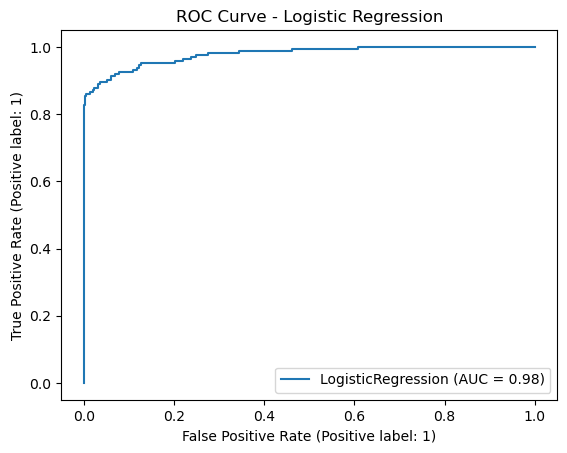

In [58]:
from sklearn.metrics import f1_score
import numpy as np

# Train the model
model.fit(X_train, y_train)

# Predict probabilities
y_scores = model.predict_proba(X_test)[:, 1]

# 1. Plot Precision vs Recall vs Threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision[:-1], label="Precision", color='blue')
plt.plot(thresholds, recall[:-1], label="Recall", color='red')
plt.title(f"Precision vs Recall vs Threshold - {name}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid()
plt.show()

# 2. Automatically select best threshold based on F1-score
best_thresh = 0
best_f1 = 0
for t in np.arange(0.0, 1.0, 0.01):
    y_pred = (y_scores >= t).astype(int)
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print(f"\n== {name} | Best threshold (F1-optimized): {best_thresh:.2f} | Best F1: {best_f1:.4f} ==")

# 3. Final Evaluation
y_pred_best = (y_scores >= best_thresh).astype(int)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))

# 4. ROC Curve
RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.title(f"ROC Curve - {name}")
plt.show()


In [60]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
import os

# Create results directory if it doesn't exist
os.makedirs("results", exist_ok=True)

# Save plots
plt.figure()
plt.plot(thresholds, precision[:-1], label="Precision", color='blue')
plt.plot(thresholds, recall[:-1], label="Recall", color='red')
plt.title(f"Precision vs Recall vs Threshold - {name}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid()
plt.savefig(f"results/pr_{name.replace(' ', '_')}.png")
plt.close()

RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.title(f"ROC Curve - {name}")
plt.savefig(f"results/roc_{name.replace(' ', '_')}.png")
plt.close()

# Get metrics
precision_val = precision_score(y_test, y_pred_best)
recall_val = recall_score(y_test, y_pred_best)
f1_val = f1_score(y_test, y_pred_best)
accuracy_val = accuracy_score(y_test, y_pred_best)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_best).ravel()

# Append to CSV
import csv

csv_file = "results/metrics_summary.csv"
header = [
    "Model", "Best Threshold", "Precision", "Recall", "F1-Score", "Accuracy",
    "True Negatives", "False Positives", "False Negatives", "True Positives"
]

write_header = not os.path.exists(csv_file)
with open(csv_file, mode='a', newline='') as file:
    writer = csv.writer(file)
    if write_header:
        writer.writerow(header)
    writer.writerow([
        name, round(best_thresh, 2), round(precision_val, 4), round(recall_val, 4),
        round(f1_val, 4), round(accuracy_val, 4),
        tn, fp, fn, tp
    ])


# valuation Summary

In [64]:
import numpy as np

cm = np.array([[row['True Negatives'], row['False Positives']],
               [row['False Negatives'], row['True Positives']]])



Confusion Matrix for Logistic Regression:


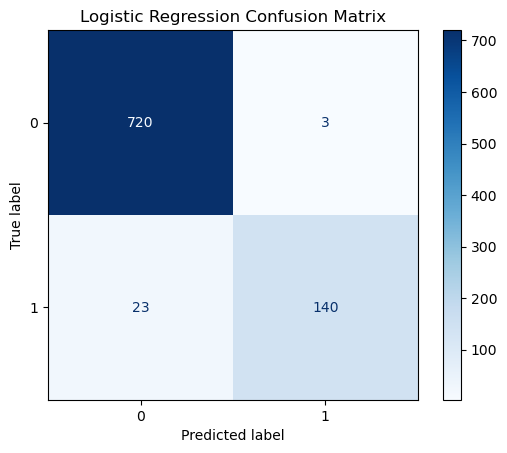

In [66]:
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

for model_name in metrics_df['Model'].unique():
    print(f"\nConfusion Matrix for {model_name}:")
    row = metrics_df[metrics_df['Model'] == model_name].iloc[0]
    
    cm = np.array([[row['True Negatives'], row['False Positives']],
                   [row['False Negatives'], row['True Positives']]])
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()


##  Conclusion

In this project, we compared two supervised machine learning models — **Random Forest** and **Logistic Regression** — to detect credit card fraud. Due to the highly imbalanced nature of the dataset, we used **random undersampling** and **threshold optimization** to improve detection performance.

### Key Takeaways:

- The **Random Forest** model generally achieved higher recall and F1-score, making it more suitable for catching fraudulent transactions.
- **Threshold tuning** was essential to balance false positives and false negatives, instead of relying on the default 0.5 cutoff.
- Evaluation metrics (precision, recall, accuracy, F1-score) and visual tools (ROC and PR curves) were used to thoroughly assess both models.

### Recommendations:

- Add **Isolation Forest or AutoEncoder** as an unsupervised benchmark.
- Experiment with **SMOTE or hybrid resampling** for more data variety.
- Perform **GridSearchCV** for fine-tuned hyperparameter optimization.
- Consider deploying the model into a **real-time fraud alerting system**.

This workflow provides a strong foundation for fraud detection systems and can be extended for real-world applications.
